# Long Short Term Memory (LSTM) - Playing with parameters

In [1]:
# Import libraries to use
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math, time, csv
from collections import defaultdict
from math import sqrt

In [2]:
# Load datasets & Analysis
csv_file = './data/TM.csv'
dfTM = pd.read_csv(csv_file, index_col='Date',parse_dates=True)    # Toyota Motor
# dfAP = pd.read_csv('./data/AAPL.csv', index_col='Date',parse_dates=True)  # Apple
# dfGE = pd.read_csv('./data/GE.csv', index_col='Date',parse_dates=True)    # General Electric
# dfMS = pd.read_csv('./data/MSFT.csv', index_col='Date',parse_dates=True)  # Microsoft
# dfSP = pd.read_csv('./data/^GSPC.csv', index_col='Date',parse_dates=True) # S&P 500
dfTM.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-07-24,123.779999,123.779999,122.309998,122.489998,98.390572,418000
2007-07-25,123.389999,123.410004,121.500000,122.290001,98.229897,557900
2007-07-26,122.320000,122.349998,117.050003,119.199997,95.747864,1258500
2007-07-27,121.739998,121.739998,119.040001,120.480003,96.776016,679900
2007-07-30,122.120003,122.599998,121.000000,121.790001,97.828300,639300


## Load libraries for LSTM model

In [3]:
# Load libraries
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

Using TensorFlow backend.


### Helper functions

In [4]:
# Load only 'Adj Close' column from CSV
def load_adj_close(filePath):
    columns = defaultdict(list) # each value in each column is appended to a list

    with open(filePath) as f:
        reader = csv.DictReader(f)    # read rows into a dictionary format
        for row in reader:            # read a row as {column1: value1, column2: value2,...}
            for (k,v) in row.items(): # go over each column name and value 
                columns[k].append(v)  # append the value into the appropriate list based on column name k

    return columns['Adj Close']

# Loading datasets and turn them into training and testing sets
def load_data_split_train_test(data, seq_len, normalise_window):
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

# Normalize function
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

### LSTM Model variables

In [14]:
# Change params and variables
batch_size = 1 #128, 258, 512
nb_epoch = 10 # 1, 3
seq_len = 50 # 30
input_dim=1
output_dim=50
loss='mean_squared_error'
optimizer = 'rmsprop'
activation = 'linear'

### Playing with several variables

### Toyota - experiment 1

/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # This is added back by InteractiveShellApp.init_path()
/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=50, return_sequences=False, input_shape=(None, 1))`
  # This is added back by InteractiveShellApp.init_path()
/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


compilation time :  0.0455679893494
Train on 2109 samples, validate on 111 samples
Epoch 1/10
2109/2109 [==============================] - 398s - loss: 6.3976e-04 - val_loss: 4.3082e-04
Epoch 2/10
2109/2109 [==============================] - 396s - loss: 3.7858e-04 - val_loss: 3.2392e-04
Epoch 3/10
2109/2109 [==============================] - 396s - loss: 3.5719e-04 - val_loss: 3.1188e-04
Epoch 4/10
2109/2109 [==============================] - 403s - loss: 3.6138e-04 - val_loss: 2.8885e-04
Epoch 5/10
2109/2109 [==============================] - 404s - loss: 3.5394e-04 - val_loss: 2.8651e-04
Epoch 6/10
2109/2109 [==============================] - 407s - loss: 3.5269e-04 - val_loss: 2.8576e-04
Epoch 7/10
2109/2109 [==============================] - 399s - loss: 3.5318e-04 - val_loss: 3.4020e-04
Epoch 8/10
2109/2109 [==============================] - 399s - loss: 3.5093e-04 - val_loss: 2.9825e-04
Epoch 9/10
2109/2109 [==============================] - 395s - loss: 3.4290e-04 - val_loss: 2

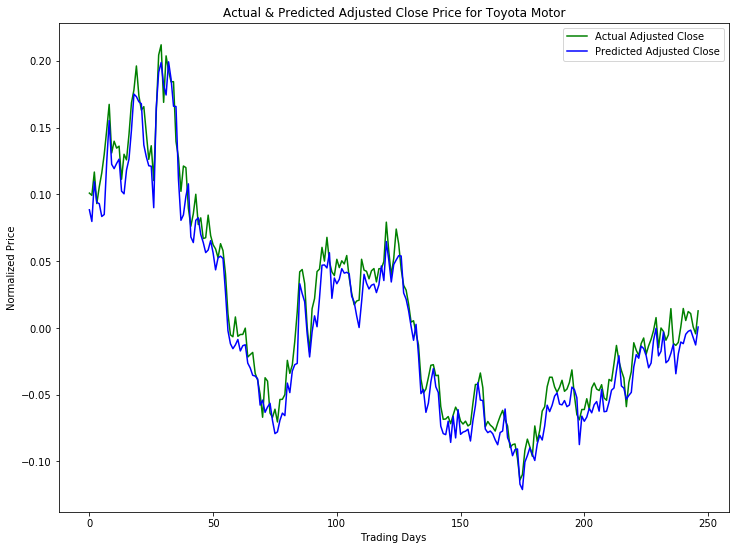

In [15]:
# Change params and variables
batch_size = 1 #128, 258, 512
nb_epoch = 10 # 1, 3
seq_len = 50 # 30
input_dim=1
output_dim=50
loss='mean_squared_error'
optimizer = 'rmsprop'
activation = 'linear'

# Get Adjusted Close price and split the data
adj_closes = load_adj_close(csv_file)
X_train_, y_train_, X_test_, y_test_ = load_data_split_train_test(adj_closes, seq_len, True)

# Build Model
model = Sequential()

model.add(LSTM(
    input_dim=input_dim,
    output_dim=output_dim,
    return_sequences=False))

model.add(Dense(output_dim=1))
model.add(Activation(activation))

start = time.time()
model.compile(loss=loss, optimizer=optimizer)
print 'compilation time : ', time.time() - start

#Train the model
model.fit(
    X_train_,
    y_train_,
    batch_size=batch_size,
    nb_epoch=nb_epoch,
    validation_split=0.05)

testPredict = model.predict(X_test_, batch_size=batch_size)
score = model.evaluate(X_test_, y_test_, batch_size=batch_size, verbose=0)

TM_MSE = score
TM_RMSE = math.sqrt(score)
print 'Mean squared error (MSE)', TM_MSE
print 'Root Mean squared error (RMSE)', TM_RMSE

# Set up plot
plt.rcParams['figure.figsize'] = (12, 9)

fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Normalized Price')
plt.xlabel('Trading Days')

# Plot actual and predicted close values
plt.plot(y_test_,'g', label='Actual Adjusted Close')
plt.plot(testPredict, 'b', label='Predicted Adjusted Close')

# Set title
ax.set_title('Actual & Predicted Adjusted Close Price for Toyota Motor')
ax.legend(loc='upper right')

plt.show()

### Toyota - experiment 2

/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=50, return_sequences=True, input_shape=(None, 1))`
/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:29: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


compilation time :  0.0453951358795
Train on 2109 samples, validate on 111 samples
Epoch 1/5
2109/2109 [==============================] - 759s - loss: 0.0012 - val_loss: 0.0013
Epoch 2/5
2109/2109 [==============================] - 753s - loss: 7.4534e-04 - val_loss: 4.5689e-04
Epoch 3/5
2109/2109 [==============================] - 751s - loss: 6.2670e-04 - val_loss: 4.4192e-04
Epoch 4/5
2109/2109 [==============================] - 757s - loss: 6.1885e-04 - val_loss: 4.4568e-04
Epoch 5/5
2109/2109 [==============================] - 750s - loss: 5.4687e-04 - val_loss: 5.9319e-04
Mean squared error (MSE) 0.000273111962431
Root Mean squared error (RMSE) 0.0165260994318


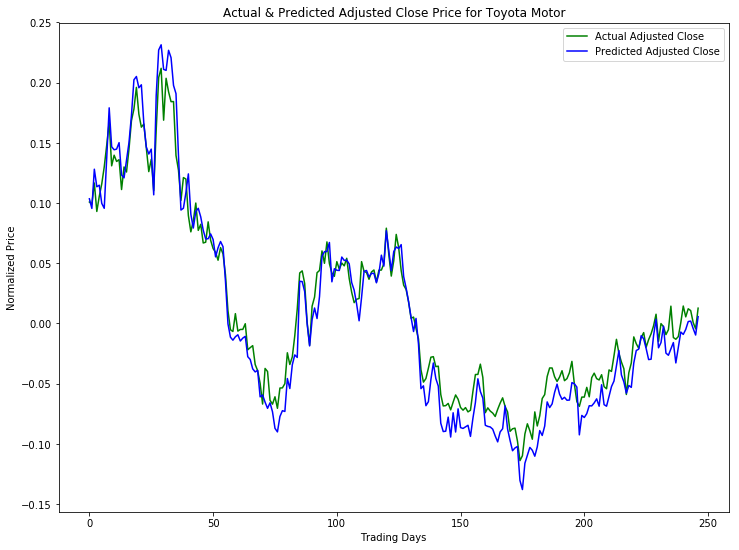

In [18]:
# Change params and variables
batch_size = 1 #128, 258, 512
nb_epoch = 5 # 1, 3
seq_len = 50 # 30
input_dim=1
output_dim=50
loss='mean_squared_error'
optimizer = 'rmsprop'
activation = 'linear'

# Get Adjusted Close price and split the data
adj_closes = load_adj_close(csv_file)
X_train_, y_train_, X_test_, y_test_ = load_data_split_train_test(adj_closes, seq_len, True)

# Build Model
model = Sequential()

model.add(LSTM(
    input_dim=input_dim,
    output_dim=output_dim,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(output_dim=1))
model.add(Activation(activation))

start = time.time()
model.compile(loss=loss, optimizer=optimizer)
print 'compilation time : ', time.time() - start

#Train the model
model.fit(
    X_train_,
    y_train_,
    batch_size=batch_size,
    nb_epoch=nb_epoch,
    validation_split=0.05)

testPredict = model.predict(X_test_, batch_size=batch_size)
score = model.evaluate(X_test_, y_test_, batch_size=batch_size, verbose=0)

TM_MSE = score
TM_RMSE = math.sqrt(score)
print 'Mean squared error (MSE)', TM_MSE
print 'Root Mean squared error (RMSE)', TM_RMSE

# Set up plot
plt.rcParams['figure.figsize'] = (12, 9)

fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Normalized Price')
plt.xlabel('Trading Days')

# Plot actual and predicted close values
plt.plot(y_test_,'g', label='Actual Adjusted Close')
plt.plot(testPredict, 'b', label='Predicted Adjusted Close')

# Set title
ax.set_title('Actual & Predicted Adjusted Close Price for Toyota Motor')
ax.legend(loc='upper right')

plt.show()


### Toyota - experiment 3

/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=50, return_sequences=True, input_shape=(None, 1))`
/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:29: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


compilation time :  0.0511319637299
Train on 2066 samples, validate on 109 samples
Epoch 1/5
2066/2066 [==============================] - 32s - loss: 0.0100 - val_loss: 0.0016
Epoch 2/5
2066/2066 [==============================] - 28s - loss: 0.0016 - val_loss: 0.0017
Epoch 3/5
2066/2066 [==============================] - 28s - loss: 0.0015 - val_loss: 0.0014
Epoch 4/5
2066/2066 [==============================] - 28s - loss: 0.0016 - val_loss: 0.0012
Epoch 5/5
2066/2066 [==============================] - 28s - loss: 0.0016 - val_loss: 0.0033
Mean squared error (MSE) 0.00143158305528
Root Mean squared error (RMSE) 0.0378362664025


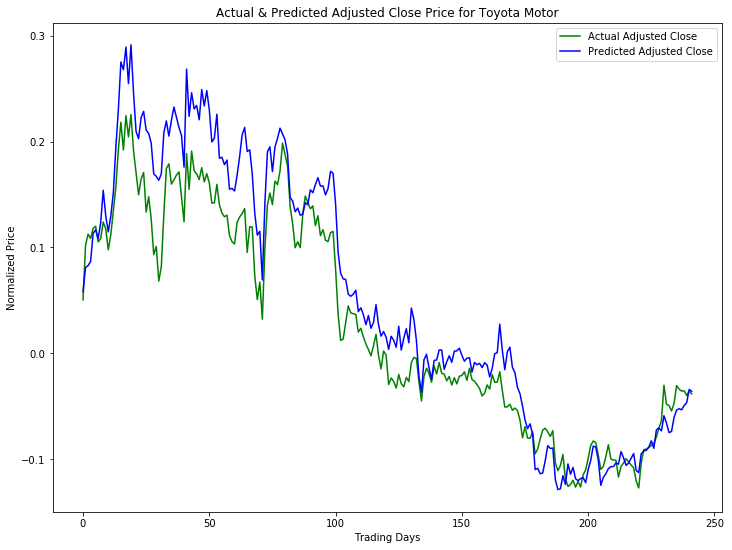

In [19]:
# Change params and variables
batch_size = 128 # 258, 512
nb_epoch = 5 # 1, 3
seq_len = 100 # 30
input_dim=1
output_dim=50
loss='mean_squared_error'
optimizer = 'rmsprop'
activation = 'linear'

# Get Adjusted Close price and split the data
adj_closes = load_adj_close(csv_file)
X_train_, y_train_, X_test_, y_test_ = load_data_split_train_test(adj_closes, seq_len, True)

# Build Model
model = Sequential()

model.add(LSTM(
    input_dim=input_dim,
    output_dim=output_dim,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    200,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(output_dim=1))
model.add(Activation(activation))

start = time.time()
model.compile(loss=loss, optimizer=optimizer)
print 'compilation time : ', time.time() - start

#Train the model
model.fit(
    X_train_,
    y_train_,
    batch_size=batch_size,
    nb_epoch=nb_epoch,
    validation_split=0.05)

testPredict = model.predict(X_test_, batch_size=batch_size)
score = model.evaluate(X_test_, y_test_, batch_size=batch_size, verbose=0)

TM_MSE = score
TM_RMSE = math.sqrt(score)
print 'Mean squared error (MSE)', TM_MSE
print 'Root Mean squared error (RMSE)', TM_RMSE

# Set up plot
plt.rcParams['figure.figsize'] = (12, 9)

fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Normalized Price')
plt.xlabel('Trading Days')

# Plot actual and predicted close values
plt.plot(y_test_,'g', label='Actual Adjusted Close')
plt.plot(testPredict, 'b', label='Predicted Adjusted Close')

# Set title
ax.set_title('Actual & Predicted Adjusted Close Price for Toyota Motor')
ax.legend(loc='upper right')

plt.show()

### Toyota - Experiment 4

/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=50, return_sequences=False, input_shape=(None, 1))`
/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


compilation time :  0.0416920185089
Train on 2066 samples, validate on 109 samples
Epoch 1/5
2066/2066 [==============================] - 11s - loss: 0.0045 - val_loss: 9.2662e-04
Epoch 2/5
2066/2066 [==============================] - 7s - loss: 0.0012 - val_loss: 0.0013
Epoch 3/5
2066/2066 [==============================] - 7s - loss: 0.0011 - val_loss: 6.7545e-04
Epoch 4/5
2066/2066 [==============================] - 7s - loss: 9.2903e-04 - val_loss: 7.8253e-04
Epoch 5/5
2066/2066 [==============================] - 7s - loss: 8.5480e-04 - val_loss: 7.0165e-04
Mean squared error (MSE) 0.00035159466805
Root Mean squared error (RMSE) 0.018750857795


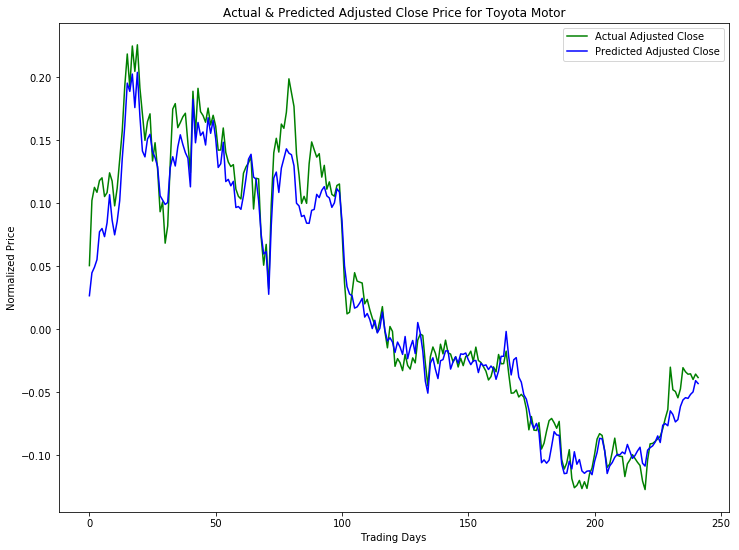

In [21]:
# Change params and variables
batch_size = 128 # 258, 512
nb_epoch = 5 # 1, 3
seq_len = 100 # 30
input_dim=1
output_dim=50
loss='mean_squared_error'
optimizer = 'rmsprop'
activation = 'linear'

# Get Adjusted Close price and split the data
adj_closes = load_adj_close(csv_file)
X_train_, y_train_, X_test_, y_test_ = load_data_split_train_test(adj_closes, seq_len, True)

# Build Model
model = Sequential()

model.add(LSTM(
    input_dim=input_dim,
    output_dim=output_dim,
    return_sequences=False))

model.add(Dense(output_dim=1))
model.add(Activation(activation))

start = time.time()
model.compile(loss=loss, optimizer=optimizer)
print 'compilation time : ', time.time() - start

#Train the model
model.fit(
    X_train_,
    y_train_,
    batch_size=batch_size,
    nb_epoch=nb_epoch,
    validation_split=0.05)

testPredict = model.predict(X_test_, batch_size=batch_size)
score = model.evaluate(X_test_, y_test_, batch_size=batch_size, verbose=0)

TM_MSE = score
TM_RMSE = math.sqrt(score)
print 'Mean squared error (MSE)', TM_MSE
print 'Root Mean squared error (RMSE)', TM_RMSE

# Set up plot
plt.rcParams['figure.figsize'] = (12, 9)

fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Normalized Price')
plt.xlabel('Trading Days')

# Plot actual and predicted close values
plt.plot(y_test_,'g', label='Actual Adjusted Close')
plt.plot(testPredict, 'b', label='Predicted Adjusted Close')

# Set title
ax.set_title('Actual & Predicted Adjusted Close Price for Toyota Motor')
ax.legend(loc='upper right')

plt.show()

### Toyota - Experiment 5

/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=50, return_sequences=False, input_shape=(None, 1))`
/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


compilation time :  0.0480208396912
Train on 1980 samples, validate on 105 samples
Epoch 1/5
1980/1980 [==============================] - 11s - loss: 0.0431 - val_loss: 0.0198
Epoch 2/5
1980/1980 [==============================] - 7s - loss: 0.0150 - val_loss: 0.0038
Epoch 3/5
1980/1980 [==============================] - 8s - loss: 0.0033 - val_loss: 0.0028
Epoch 4/5
1980/1980 [==============================] - 7s - loss: 0.0023 - val_loss: 0.0023
Epoch 5/5
1980/1980 [==============================] - 9s - loss: 0.0018 - val_loss: 0.0023
Mean squared error (MSE) 0.000587560993154
Root Mean squared error (RMSE) 0.0242396574471


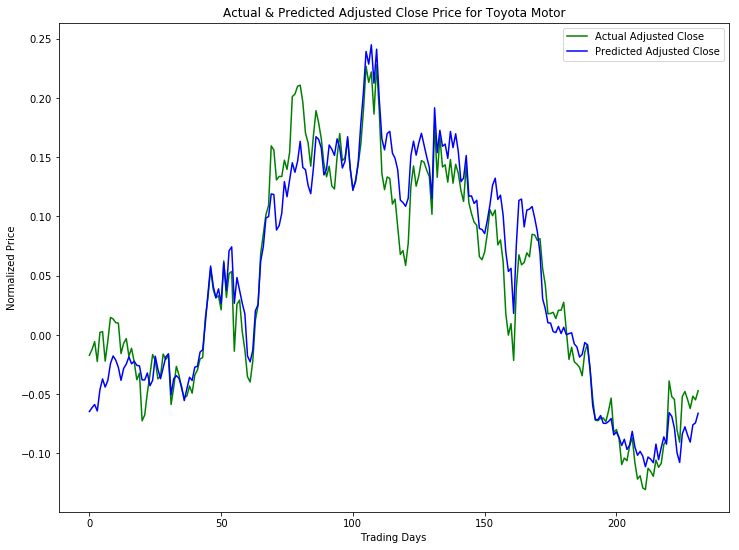

In [22]:
# Change params and variables
batch_size = 512
nb_epoch = 5 # 1, 3
seq_len = 200 # 30
input_dim=1
output_dim=50
loss='mean_squared_error'
optimizer = 'rmsprop'
activation = 'linear'

# Get Adjusted Close price and split the data
adj_closes = load_adj_close(csv_file)
X_train_, y_train_, X_test_, y_test_ = load_data_split_train_test(adj_closes, seq_len, True)

# Build Model
model = Sequential()

model.add(LSTM(
    input_dim=input_dim,
    output_dim=output_dim,
    return_sequences=False))

model.add(Dense(output_dim=1))
model.add(Activation(activation))

start = time.time()
model.compile(loss=loss, optimizer=optimizer)
print 'compilation time : ', time.time() - start

#Train the model
model.fit(
    X_train_,
    y_train_,
    batch_size=batch_size,
    nb_epoch=nb_epoch,
    validation_split=0.05)

testPredict = model.predict(X_test_, batch_size=batch_size)
score = model.evaluate(X_test_, y_test_, batch_size=batch_size, verbose=0)

TM_MSE = score
TM_RMSE = math.sqrt(score)
print 'Mean squared error (MSE)', TM_MSE
print 'Root Mean squared error (RMSE)', TM_RMSE

# Set up plot
plt.rcParams['figure.figsize'] = (12, 9)

fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Normalized Price')
plt.xlabel('Trading Days')

# Plot actual and predicted close values
plt.plot(y_test_,'g', label='Actual Adjusted Close')
plt.plot(testPredict, 'b', label='Predicted Adjusted Close')

# Set title
ax.set_title('Actual & Predicted Adjusted Close Price for Toyota Motor')
ax.legend(loc='upper right')

plt.show()

### Toyota - Experiment 6

/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=50, return_sequences=False, input_shape=(None, 1))`
/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


compilation time :  0.0529952049255
Train on 2109 samples, validate on 111 samples
Epoch 1/10
2109/2109 [==============================] - 380s - loss: 7.6126e-04 - val_loss: 3.3819e-04
Epoch 2/10
2109/2109 [==============================] - 369s - loss: 3.8635e-04 - val_loss: 4.6044e-04
Epoch 3/10
2109/2109 [==============================] - 367s - loss: 3.6583e-04 - val_loss: 2.9496e-04
Epoch 4/10
2109/2109 [==============================] - 383s - loss: 3.5016e-04 - val_loss: 2.8053e-04
Epoch 5/10
2109/2109 [==============================] - 380s - loss: 3.5916e-04 - val_loss: 3.4456e-04
Epoch 6/10
2109/2109 [==============================] - 382s - loss: 3.4400e-04 - val_loss: 4.3355e-04
Epoch 7/10
2109/2109 [==============================] - 391s - loss: 3.4840e-04 - val_loss: 2.8464e-04
Epoch 8/10
2109/2109 [==============================] - 381s - loss: 3.4316e-04 - val_loss: 2.7209e-04
Epoch 9/10
2109/2109 [==============================] - 381s - loss: 3.5056e-04 - val_loss: 3

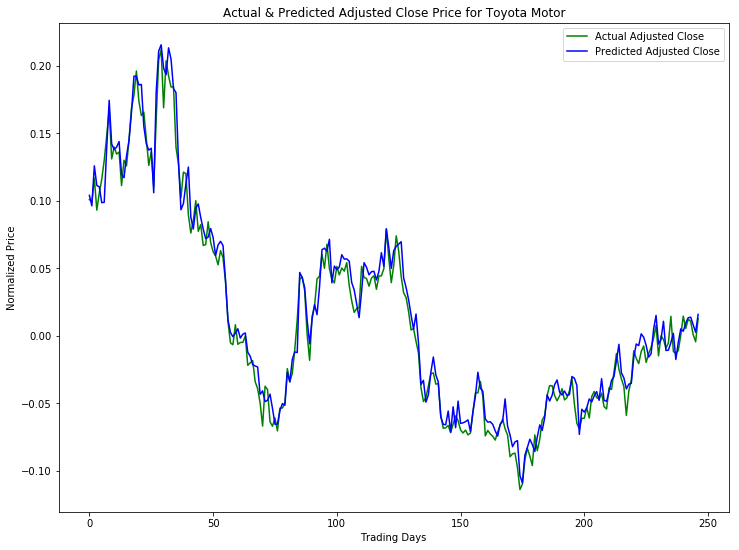

In [23]:
# Change params and variables
batch_size = 1 # 258, 512
nb_epoch = 10 # 1, 3
seq_len = 50 # 30
input_dim=1
output_dim=50
loss='mean_squared_error'
optimizer = 'rmsprop'
activation = 'linear'

# Get Adjusted Close price and split the data
adj_closes = load_adj_close(csv_file)
X_train_, y_train_, X_test_, y_test_ = load_data_split_train_test(adj_closes, seq_len, True)

# Build Model
model = Sequential()

model.add(LSTM(
    input_dim=input_dim,
    output_dim=output_dim,
    return_sequences=False))

model.add(Dense(output_dim=1))
model.add(Activation(activation))

start = time.time()
model.compile(loss=loss, optimizer=optimizer)
print 'compilation time : ', time.time() - start

#Train the model
model.fit(
    X_train_,
    y_train_,
    batch_size=batch_size,
    nb_epoch=nb_epoch,
    validation_split=0.05)

testPredict = model.predict(X_test_, batch_size=batch_size)
score = model.evaluate(X_test_, y_test_, batch_size=batch_size, verbose=0)

TM_MSE = score
TM_RMSE = math.sqrt(score)
print 'Mean squared error (MSE)', TM_MSE
print 'Root Mean squared error (RMSE)', TM_RMSE

# Set up plot
plt.rcParams['figure.figsize'] = (12, 9)

fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Normalized Price')
plt.xlabel('Trading Days')

# Plot actual and predicted close values
plt.plot(y_test_,'g', label='Actual Adjusted Close')
plt.plot(testPredict, 'b', label='Predicted Adjusted Close')

# Set title
ax.set_title('Actual & Predicted Adjusted Close Price for Toyota Motor')
ax.legend(loc='upper right')

plt.show()

### Toyota - Experiment 7

/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=50, return_sequences=False, input_shape=(None, 1))`
/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


compilation time :  0.0648641586304
Train on 2143 samples, validate on 113 samples
Epoch 1/5
2143/2143 [==============================] - 91s - loss: 5.0316e-04 - val_loss: 2.7939e-04
Epoch 2/5
2143/2143 [==============================] - 88s - loss: 3.5896e-04 - val_loss: 2.9461e-04
Epoch 3/5
2143/2143 [==============================] - 88s - loss: 3.5496e-04 - val_loss: 2.7669e-04
Epoch 4/5
2143/2143 [==============================] - 85s - loss: 3.5803e-04 - val_loss: 2.7370e-04
Epoch 5/5
2143/2143 [==============================] - 86s - loss: 3.5674e-04 - val_loss: 2.8349e-04
Mean squared error (MSE) 9.6412006261e-05
Root Mean squared error (RMSE) 0.00981896156734


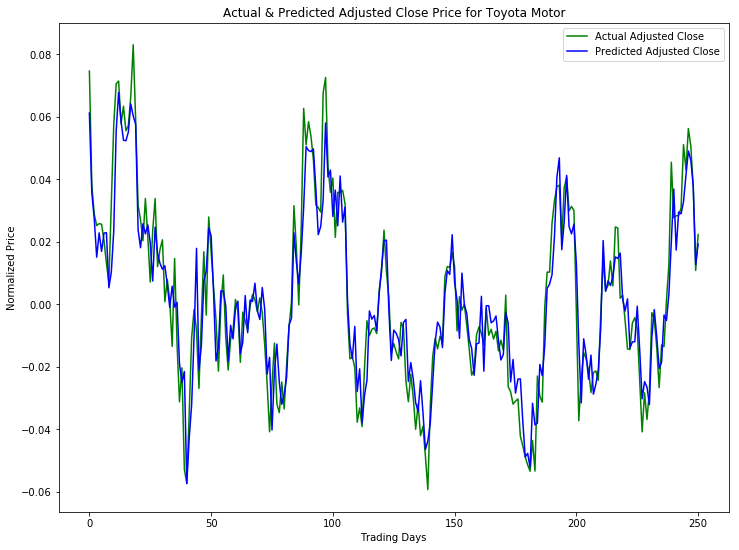

In [24]:
# Change params and variables
batch_size = 1 # 258, 512
nb_epoch = 5 # 1, 3
seq_len = 10 # 30
input_dim=1
output_dim=50
loss='mean_squared_error'
optimizer = 'rmsprop'
activation = 'linear'

# Get Adjusted Close price and split the data
adj_closes = load_adj_close(csv_file)
X_train_, y_train_, X_test_, y_test_ = load_data_split_train_test(adj_closes, seq_len, True)

# Build Model
model = Sequential()

model.add(LSTM(
    input_dim=input_dim,
    output_dim=output_dim,
    return_sequences=False))

model.add(Dense(output_dim=1))
model.add(Activation(activation))

start = time.time()
model.compile(loss=loss, optimizer=optimizer)
print 'compilation time : ', time.time() - start

#Train the model
model.fit(
    X_train_,
    y_train_,
    batch_size=batch_size,
    nb_epoch=nb_epoch,
    validation_split=0.05)

testPredict = model.predict(X_test_, batch_size=batch_size)
score = model.evaluate(X_test_, y_test_, batch_size=batch_size, verbose=0)

TM_MSE = score
TM_RMSE = math.sqrt(score)
print 'Mean squared error (MSE)', TM_MSE
print 'Root Mean squared error (RMSE)', TM_RMSE

# Set up plot
plt.rcParams['figure.figsize'] = (12, 9)

fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Normalized Price')
plt.xlabel('Trading Days')

# Plot actual and predicted close values
plt.plot(y_test_,'g', label='Actual Adjusted Close')
plt.plot(testPredict, 'b', label='Predicted Adjusted Close')

# Set title
ax.set_title('Actual & Predicted Adjusted Close Price for Toyota Motor')
ax.legend(loc='upper right')

plt.show()

### Apple

In [ ]:
# Load datasets
csv_file = './data/AAPL.csv'
dfTM = pd.read_csv(csv_file, index_col='Date',parse_dates=True)

# Change params and variables
batch_size = 1
nb_epoch = 1
seq_len = 5
input_dim=1
output_dim=50
loss='mean_squared_error'
optimizer = 'rmsprop'
activation = 'linear'

# Get Adjusted Close price and split the data
adj_closes = load_adj_close(csv_file)
X_train_, y_train_, X_test_, y_test_ = load_data_split_train_test(adj_closes, seq_len, True)

# Build Model
model = Sequential()

model.add(LSTM(
    input_dim=input_dim,
    output_dim=output_dim,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss=loss, optimizer=optimizer)
print 'compilation time : ', time.time() - start

#Train the model
model.fit(
    X_train_,
    y_train_,
    batch_size=batch_size,
    nb_epoch=nb_epoch,
    validation_split=0.05)


testPredict = model.predict(X_test_, batch_size=batch_size)
score = model.evaluate(X_test_, y_test_, batch_size=batch_size, verbose=0)

APPL_MSE = score
APPL_RMSE = math.sqrt(score)
print 'Mean squared error (MSE)', APPL_MSE
print 'Root Mean squared error (RMSE)', APPL_RMSE

# Set up plot
plt.rcParams['figure.figsize'] = (12, 9)

fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Normalized Price')
plt.xlabel('Trading Days')

# Plot actual and predicted close values
plt.plot(y_test_,'g', label='Actual Adjusted Close')
plt.plot(testPredict, 'b', label='Predicted Adjusted Close')

# Set title
ax.set_title('Actual & Predicted Adjusted Close Price for Apple')
ax.legend(loc='upper right')

plt.show()

### GE

In [ ]:
# Load datasets
csv_file = './data/GE.csv'
dfTM = pd.read_csv(csv_file, index_col='Date',parse_dates=True)

# Change params and variables
batch_size = 1
nb_epoch = 1
seq_len = 5
input_dim=1
output_dim=50
loss='mean_squared_error'
optimizer = 'rmsprop'
activation = 'linear'

# Get Adjusted Close price and split the data
adj_closes = load_adj_close(csv_file)
X_train_, y_train_, X_test_, y_test_ = load_data_split_train_test(adj_closes, seq_len, True)

# Build Model
model = Sequential()

model.add(LSTM(
    input_dim=input_dim,
    output_dim=output_dim,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss=loss, optimizer=optimizer)
print 'compilation time : ', time.time() - start

#Train the model
model.fit(
    X_train_,
    y_train_,
    batch_size=batch_size,
    nb_epoch=nb_epoch,
    validation_split=0.05)


testPredict = model.predict(X_test_, batch_size=batch_size)
score = model.evaluate(X_test_, y_test_, batch_size=batch_size, verbose=0)

GE_MSE = score
GE_RMSE = math.sqrt(score)
print 'Mean squared error (MSE)', GE_MSE
print 'Root Mean squared error (RMSE)', GE_RMSE

# Set up plot
plt.rcParams['figure.figsize'] = (12, 9)

fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Normalized Price')
plt.xlabel('Trading Days')

# Plot actual and predicted close values
plt.plot(y_test_,'g', label='Actual Adjusted Close')
plt.plot(testPredict, 'b', label='Predicted Adjusted Close')

# Set title
ax.set_title('Actual & Predicted Adjusted Close Price for GE')
ax.legend(loc='upper right')

plt.show()

### Microsoft

In [ ]:
# Load datasets
csv_file = './data/MSFT.csv'
dfTM = pd.read_csv(csv_file, index_col='Date',parse_dates=True)

# Change params and variables
batch_size = 1
nb_epoch = 1
seq_len = 5
input_dim=1
output_dim=50
loss='mean_squared_error'
optimizer = 'rmsprop'
activation = 'linear'

# Get Adjusted Close price and split the data
adj_closes = load_adj_close(csv_file)
X_train_, y_train_, X_test_, y_test_ = load_data_split_train_test(adj_closes, seq_len, True)

# Build Model
model = Sequential()

model.add(LSTM(
    input_dim=input_dim,
    output_dim=output_dim,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss=loss, optimizer=optimizer)
print 'compilation time : ', time.time() - start

#Train the model
model.fit(
    X_train_,
    y_train_,
    batch_size=batch_size,
    nb_epoch=nb_epoch,
    validation_split=0.05)


testPredict = model.predict(X_test_, batch_size=batch_size)
score = model.evaluate(X_test_, y_test_, batch_size=batch_size, verbose=0)

MSFT_MSE = score
MSFT_RMSE = math.sqrt(score)
print 'Mean squared error (MSE)', MSFT_MSE
print 'Root Mean squared error (RMSE)', MSFT_RMSE

# Set up plot
plt.rcParams['figure.figsize'] = (12, 9)

fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Normalized Price')
plt.xlabel('Trading Days')

# Plot actual and predicted close values
plt.plot(y_test_,'g', label='Actual Adjusted Close')
plt.plot(testPredict, 'b', label='Predicted Adjusted Close')

# Set title
ax.set_title('Actual & Predicted Adjusted Close Price for Microsoft')
ax.legend(loc='upper right')

plt.show()

### S&P 500

In [ ]:
# Load datasets
csv_file = './data/^GSPC.csv'
dfTM = pd.read_csv(csv_file, index_col='Date',parse_dates=True)

# Change params and variables
batch_size = 1
nb_epoch = 1
seq_len = 5
input_dim=1
output_dim=50
loss='mean_squared_error'
optimizer = 'rmsprop'
activation = 'linear'

# Get Adjusted Close price and split the data
adj_closes = load_adj_close(csv_file)
X_train_, y_train_, X_test_, y_test_ = load_data_split_train_test(adj_closes, seq_len, True)

# Build Model
model = Sequential()

model.add(LSTM(
    input_dim=input_dim,
    output_dim=output_dim,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss=loss, optimizer=optimizer)
print 'compilation time : ', time.time() - start

#Train the model
model.fit(
    X_train_,
    y_train_,
    batch_size=batch_size,
    nb_epoch=nb_epoch,
    validation_split=0.05)


testPredict = model.predict(X_test_, batch_size=batch_size)
score = model.evaluate(X_test_, y_test_, batch_size=batch_size, verbose=0)

GSPC_MSE = score
GSPC_RMSE = math.sqrt(score)
print 'Mean squared error (MSE)', GSPC_MSE
print 'Root Mean squared error (RMSE)', GSPC_RMSE

# Set up plot
plt.rcParams['figure.figsize'] = (12, 9)

fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Normalized Price')
plt.xlabel('Trading Days')

# Plot actual and predicted close values
plt.plot(y_test_,'g', label='Actual Adjusted Close')
plt.plot(testPredict, 'b', label='Predicted Adjusted Close')

# Set title
ax.set_title('Actual & Predicted Adjusted Close Price for S&P 500')
ax.legend(loc='upper right')

plt.show()

### Results

In [ ]:
print 'Toyota (MSE): ', TM_MSE 
print 'Toyota (RMSE): ', TM_RMSE 
print 'Apple (MSE): ', APPL_MSE 
print 'Apple (RMSE): ', APPL_RMSE 
print 'GE (MSE): ', GE_MSE 
print 'GE (RMSE): ', GE_RMSE 
print 'Microsoft (MSE): ', MSFT_MSE 
print 'Microsoft (RMSE): ', MSFT_RMSE 
print 'S&P 500 (MSE): ', GSPC_MSE 
print 'S&P 500 (RMSE): ', GSPC_RMSE 